In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

## Download and extract file from kaggle to our system

In [4]:
api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

  0%|                                                                                      | 0.00/1.28M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:00<00:00, 1.37MB/s]


  0%|                                                                                       | 0.00/494k [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████████████████████| 494k/494k [00:00<00:00, 1.27MB/s]

## Preparing Data

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df.shape

(156060, 4)

<AxesSubplot:>

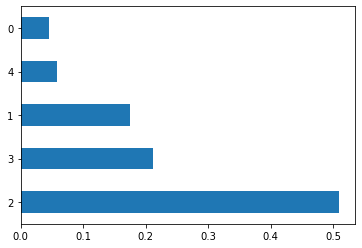

In [9]:
df['Sentiment'].value_counts(normalize=True).plot(kind='barh')

 From **Kaggle's website** we got following info:
 
The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [10]:
# tokenizing the text to create two input tensors; our input IDs, and attention mask.
seq_len = 512 # sequence length of our tokenized sequences for BERT
num_samples = len(df) # our token will be of shape len(df) * 512

In [11]:
num_samples, seq_len

(156060, 512)

## BERT - preprocesing

In [12]:
from transformers import BertTokenizer

In [13]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
# tokenize 
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [15]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
tokens['input_ids'][:10]

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]])

In [17]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [18]:
# saveing them as Numpy binary files
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
    
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [19]:
# Now that we have them on file, we can delete the in-memory arrays to free up memory
import gc
del tokens 
gc.collect()

110

our sentence are now ready, let's structure labels properly

In [20]:
# first extract sentiment column
arr = df['Sentiment'].values

In [23]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [24]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1)) # shape = len(df) * number of label classes
labels.shape

(156060, 5)

In [25]:
# use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array
labels[np.arange(num_samples), arr] = 1 

In [26]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [27]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)